# Bandpass Filtering and Phase Extraction

Step-by-step EGG signal processing: bandpass filter to the normogastric
band, then extract instantaneous phase and amplitude via the Hilbert
transform. Use this when you need more control than `egg_process` provides.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import gastropy as gp

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

In [2]:
# Load and select best channel
egg = gp.load_egg()
best_idx, _, _, _ = gp.select_best_channel(egg["signal"], egg["sfreq"])
raw = egg["signal"][best_idx]
sfreq = egg["sfreq"]
times = np.arange(len(raw)) / sfreq

## Bandpass Filter

`apply_bandpass` applies a zero-phase FIR filter. Use the band
constants or specify custom frequencies.

In [3]:
# Using the NORMOGASTRIA band constant
filtered, filt_info = gp.apply_bandpass(
    raw,
    sfreq,
    low_hz=gp.NORMOGASTRIA.f_lo,
    high_hz=gp.NORMOGASTRIA.f_hi,
)

print(f"Method: {filt_info['filter_method']}")
print(f"FIR taps: {filt_info['fir_numtaps']}")
print(f"Passband: {gp.NORMOGASTRIA.f_lo:.4f}–{gp.NORMOGASTRIA.f_hi:.4f} Hz")

Method: fir
FIR taps: 501
Passband: 0.0333–0.0667 Hz


## Hilbert Transform

In [4]:
phase, analytic = gp.instantaneous_phase(filtered)
amplitude = np.abs(analytic)

print(f"Phase range: [{phase.min():.2f}, {phase.max():.2f}] rad")
print(f"Amplitude range: [{amplitude.min():.6f}, {amplitude.max():.6f}]")

Phase range: [-3.14, 3.14] rad
Amplitude range: [0.000001, 0.001092]


## Cycle Detection

In [5]:
durations = gp.cycle_durations(phase, times)
print(f"Cycles: {len(durations)}, mean: {np.mean(durations):.1f} s, SD: {np.std(durations, ddof=1):.1f} s")

Cycles: 37, mean: 20.3 s, SD: 3.6 s


## Visualize All Steps

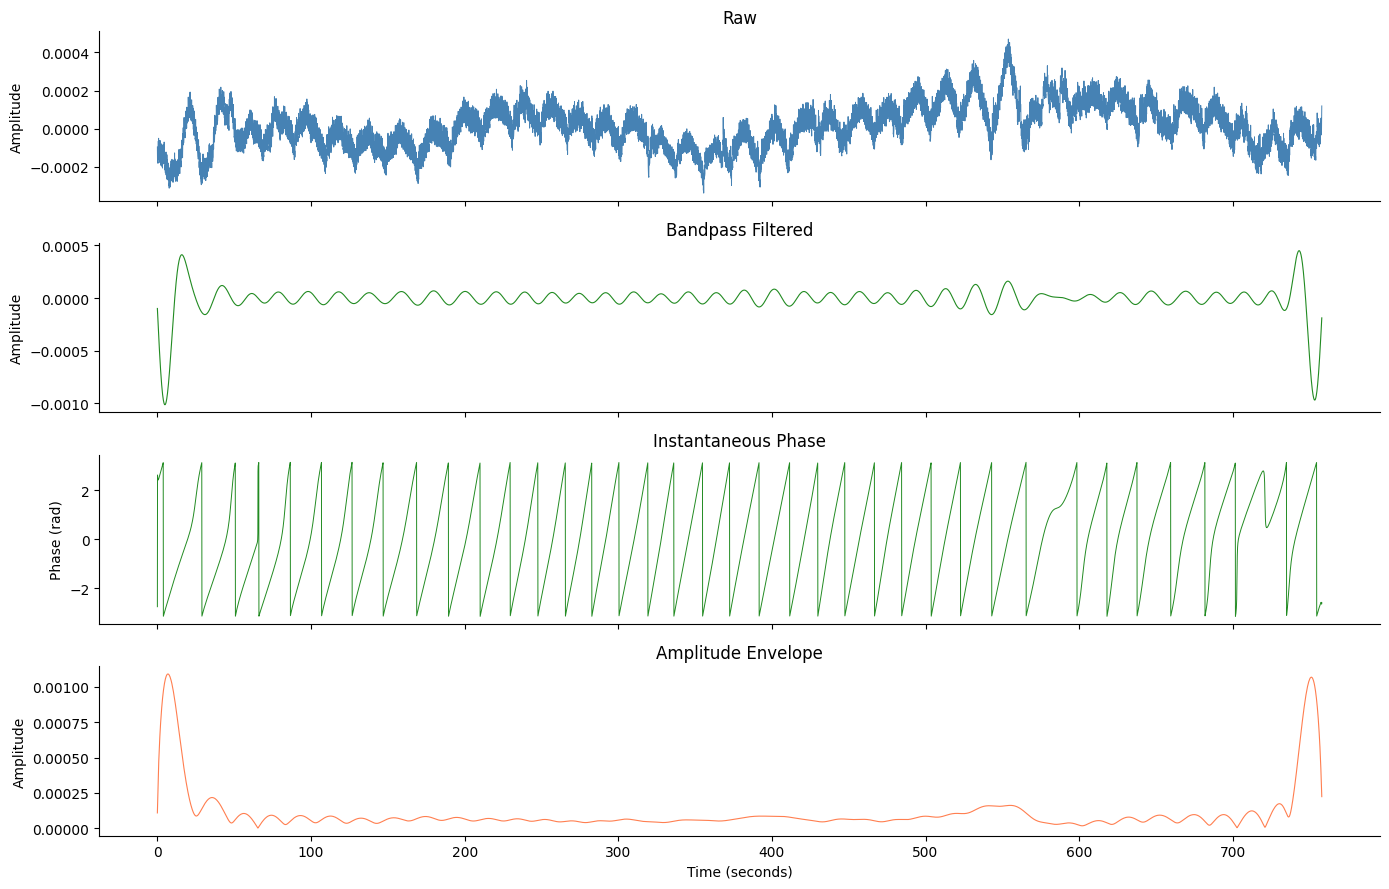

In [6]:
fig, axes = plt.subplots(4, 1, figsize=(14, 9), sharex=True)

axes[0].plot(times, raw - np.mean(raw), lw=0.7, color="steelblue")
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Raw")

axes[1].plot(times, filtered, lw=0.8, color="forestgreen")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Bandpass Filtered")

axes[2].plot(times, phase, lw=0.7, color="forestgreen")
axes[2].set_ylabel("Phase (rad)")
axes[2].set_title("Instantaneous Phase")

axes[3].plot(times, amplitude, lw=0.8, color="coral")
axes[3].set_ylabel("Amplitude")
axes[3].set_xlabel("Time (seconds)")
axes[3].set_title("Amplitude Envelope")

for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
fig.tight_layout()
plt.show()

## Sine Fitting

`fit_sine` fits `A · sin(2πft + φ)` to the filtered signal using
L-BFGS-B optimisation. It returns the fitted amplitude, phase offset,
and residual — useful for computing a clean amplitude estimate or
aligning trials to the gastric cycle.

In [7]:
# Fit a sine wave to the filtered gastric signal
# Find the peak frequency in the normogastric band from the PSD
freqs_raw, psd_raw = gp.psd_welch(raw, sfreq)
normo_mask = (freqs_raw >= gp.NORMOGASTRIA.f_lo) & (freqs_raw <= gp.NORMOGASTRIA.f_hi)
peak_hz = freqs_raw[normo_mask][np.argmax(psd_raw[normo_mask])]

sine_result = gp.fit_sine(filtered, sfreq=sfreq, freq=peak_hz)
print(f"Fitted frequency : {sine_result['freq_hz']:.4f} Hz ({sine_result['freq_hz'] * 60:.2f} cpm)")
print(f"Fitted amplitude : {sine_result['amplitude']:.6f}")
print(f"Fitted phase     : {sine_result['phase_rad']:.4f} rad")
print(f"Residual (MSE)   : {sine_result['residual']:.2e}")

Fitted frequency : 0.0530 Hz (3.18 cpm)
Fitted amplitude : 0.000029
Fitted phase     : -0.0000 rad
Residual (MSE)   : 1.44e-04


**See also:** [egg_process](egg_process.ipynb),
[PSD Parameters](psd_parameters.ipynb)